---
title: "Conjunto de modelos"
date: 2022-04-20T10:37:29+02:00
tags: [ensemble models, bagging, bootstrap, boosting, random forest, gradient-boosting,]
categories: [tutoriales]
---

En este post veremos en detalle los algoritmos que combinan varios modelos juntos, también llamados conjunto de modelos. Presentaremos dos familias de estas técnicas: (i) basados en *bootstrapping* y (ii) basados en *boosting*. Presentaremos *bagging* y *árboles aleatorios* como pertenecientes a la primera estrategia y *AdaBoost* y *árboles de decisión gradient boosting* que pertenecen a la última estrategia. Finalmente, hablaremos sobre los hiperparámetros que permiten afinar estos modelos y compararlos entre modelos.

# Ejemplo introductorio a los modelos de conjunto

En este ejemplo queremos enfatizar los beneficios de los métodos de conjunto sobre los modelos simples (por ejemplo, árbol de decisión, modelo lineal, etc.). Combinar modelos simples produce modelos más poderosos y robustos con menos problemas.

Empezaremos cargando el dataset de propiedades de California. El objetivo de este dataset es prededir el valor medio de la vivienda en algunos distritos de California basándonos en datos geofráficos y demográficos.

In [1]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
y *= 100  # reescala el objetivo en k$

Vamos a comprobar el rendimiento de generalización de un árbol de decisión regresor con los parámetros por defecto.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(tree, X, y, n_jobs=-1)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.354 +/- 0.087


Obtenemos resultados justos. Sin embargo, ya sabemos que este modelo necesita se afinado. De hecho, los parámetros por defecto no conducen necesariamente a un árbol de decisión óptimo. En lugar de usar los valores por defecto, debemos buscar a través de validación cruzada el valor óptimo de parámetros importantes, como son `max_depth`, `min_samples_split` o `min_samples_leaf`.

Recordemos que necesitamos ajustar esos parámetros, ya que los árboles de decisión adolecen de overfitting si aumenta la profundidad del árbol, pero no existen reglas de cómo se debe configurar cada parámetro. Por tanto, no realizar una búsqueda nos llevaría a tener un modelo con underfitting u overfitting.

Ahora vamos a hacer un grid search para afinar los hiperparámetros que hemos mencionado anteriormente.

In [3]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
      "max_depth": [5, 8, None],
      "min_samples_split": [2, 10, 30, 50],
      "min_samples_leaf": [0.01, 0.05, 0.1, 1]}
cv = 3

tree = GridSearchCV(DecisionTreeRegressor(random_state=0),
                    param_grid=param_grid, cv=cv, n_jobs=-1)
cv_results = cross_validate(tree, X, y, n_jobs=-1,
                            return_estimator=True)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.523 +/- 0.107
CPU times: total: 15.6 ms
Wall time: 4 s


Vemos que optimizar los hiperparámetros tiene un efecto positivo en el rendimiento de generalización. Sin embargo, conlleva un alto coste computacional.

Podemos crear un dataframe almacenando la información importante recopilada durante el ajuste de hiperparámetros e investigar los resultados.

Ahora usaremos un metodo de conjunto llamado **bagging**. Brevemente, este método usará un regresor de base (es decir, árboles de decisión regresores) y entrenará varios de ellos en una versión ligeramente modificada del conjunto de entrenamiento. Luego, las predicciones de todos esos regresores base se combinarán promediando.

Aquí, usaremos 20 árboles de decisión y comprobaremos el tiempo de entrenamiento así como el rendimiento de generalización en los datos de prueba externos. Es importante notar que no vamos a ajustar ningún parámetro del árbol de decisión.

In [4]:
%%time
from sklearn.ensemble import BaggingRegressor

base_estimator = DecisionTreeRegressor(random_state=0)
bagging_regressor = BaggingRegressor(
    base_estimator=base_estimator, n_estimators=20, random_state=0)

cv_results = cross_validate(bagging_regressor, X, y, n_jobs=-1)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.642 +/- 0.083
CPU times: total: 125 ms
Wall time: 3.35 s


Sin realizar la búsqueda de los hiperparámetros óptimos, el rendimiento de generalización global del regresor bagging es mucho mejor que un único árbol de decisión. Además, el coste computacional se reduce en comparación a la búsqueda de hiperparámetros óptimos.

Esto muestra la motivación existente detrás del uso de métodos de conjunto: proporcionan una relativamente buena baseline con un rendimiento de generalización decente sin ningún ajuste de hiperparámetros.

A continuación veremos en detalle dos familias de conjunto: bagging y boosting:

+ conjunto usando bootstrap (por ejemplo, bagging y bosques aleatorios);
+ conjunto usando boosting (por ejemplo, boosting adaptativo y álboles de decisión gradient-boosting).

# Bagging

Vamos a introducir una estrategia muy natural de construir conjuntos de modelos de machine learning llamado "bagging".

"Bagging" proviene de Bootstrap AGGregatING. Utilizas remuestreo bootstrap (muestreo aleatorio con reemplazo) para aprender varios modelos en variaciones aleatorias del conjunto de entrenamiento. A la hora de predecir, se agregan las predicciones de cada aprendiz para obtener las predicciones finales.

En primer lugar, vamos a generar un dataset sintético simple para obtener información de bootstraping.

In [6]:
import pandas as pd
import numpy as np

rng = np.random.RandomState(1)

def generate_data(n_samples=30):
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

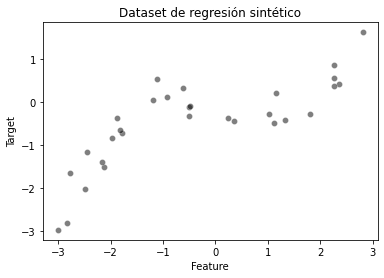

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train = generate_data(n_samples=30)
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
_ = plt.title("Dataset de regresión sintético")

La relación entre nuestras features y el objetivo a predecir es no lineal. Sin embargo, un árbol de decisión es capaz de aproximar tal dependencia no lineal:

In [8]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

En este caso, el término "test" se refiere a datos que no se han usado previamente para entrenar y calcular una métrica de evaluación en un conjunto de prueba de este tipo no tendría sentido.

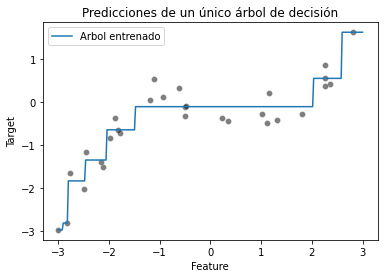

In [9]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
plt.plot(X_test["Feature"], y_pred, label="Arbol entrenado")
plt.legend()
_ = plt.title("Predicciones de un único árbol de decisión")

Veamos cómo podemos usar bottstraping para aprender varios árboles.

## Bootstrap resampling

Una muestra bootstrap corresponde a un remuestreo con reemplazo del dataset original, una muestra que tiene el mismo tamaño que el dataset original. Por lo tanto, la muestra bootstrap contendrá varias veces algunos puntos de datos, mientras que algunos de los puntos de datos originales no estarán presentes.

Crearemos una función que, dados `X` e `y`, devolverá una variación remuestreada `X_boostrap` e `y_boostrap`.

In [16]:
def bootstrap_sample(data, target):
    # indices corresponde a un muestreo con reemplazo del misma tamaño de muestra
    # que los datos originales
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

Vamos a generar 3 muestras bootstrap y verificaremos cualitativamente la diferencia con el dataset original.

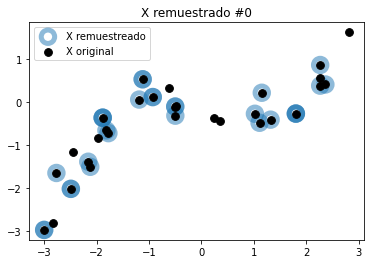

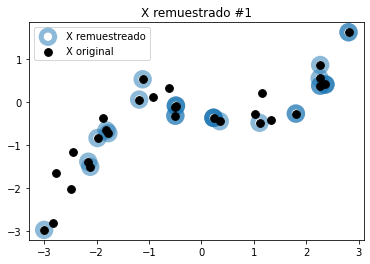

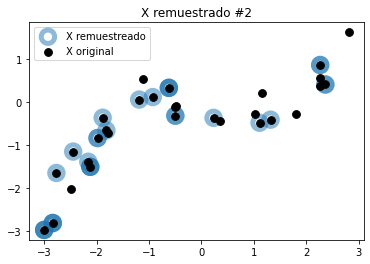

In [17]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    X_bootstrap, y_bootstrap = bootstrap_sample(
        X_train, y_train
    )
    plt.figure()
    plt.scatter(X_bootstrap["Feature"], y_bootstrap,
                color="tab:blue", facecolor="none",
                alpha=0.5, label="X remuestreado", s=180, linewidth=5)
    plt.scatter(X_train["Feature"], y_train,
                color="black", label="X original", s=60)
    plt.title(f"X remuestrado #{bootstrap_idx}")
    plt.legend()

Observemos que las tres variaciones comparten puntos comunes con el dataset original. Algunos puntos son remuestreados aleatoriamente varias veces y aparecen como círculos azul oscuro.

Las tres muestras bootstrap generadas son diferentes del dataset original y entre cada una de ellas. Para confirmar esta intuición, podemos comprobar el número de muestras únicas en las muestras bootstrap.

In [18]:
X_train_huge, X_test_huge, y_train_huge = generate_data(n_samples=100_000)
X_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(
    X_train_huge, y_train_huge)

ratio_unique_sample = (np.unique(X_bootstrap_sample).size /
                       X_bootstrap_sample.size)
print(
    f"Porcentaje de muestras presentes en el dataset original: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Porcentaje de muestras presentes en el dataset original: 63.2%


En promedio, un 63.2% de los puntos de datos del dataset original estarán presentes en una muestra bootstrap dada. El otro 36.8% son muestras repetidas. Somos capaces de generar muchos datasets, todos ligeramente diferentes.

Ahora podemos entrenar un árbol de decisión para cada uno de esos datasets y todos ellos serán también ligeramente diferentes.

In [20]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    X_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(
        X_train, y_train)
    tree.fit(X_bootstrap_sample, y_bootstrap_sample)
    bag_of_trees.append(tree)

Ahora que podemos crear una bolsa de árboles diferentes, podemos usar cada uno de los tres árboles para predecir las muestras dentro del rango de los datos. Ellos proporcionarán predicciones ligeramente diferentes.

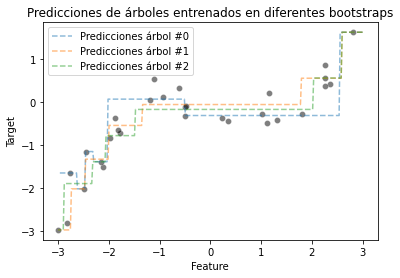

In [21]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    y_pred = tree.predict(X_test)
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.5,
             label=f"Predicciones árbol #{tree_idx}")
plt.legend()
_ = plt.title("Predicciones de árboles entrenados en diferentes bootstraps")

## Agregación

Una vez hemos entrenado nuestros árboles somos capaces de obtener predicciones de cada uno de ellos. En regresión, la forma más directa de combinar esas predicciones es promediarlas:para un punto de datos de prueba dado, alimentamos los valores de features de entrada a cada uno de los `n` models entrenados en el conjunto y, como resultado, calculamos `n` valores predichos para la variable objetivo. La predicción final del conjunto para los puntos de datos de prueba es la media de esos `n`valores.

Podemos dibujar las predicciones promediadas del ejemplo anterior.

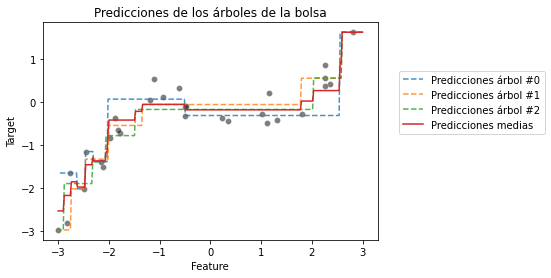

In [23]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    y_pred = tree.predict(X_test)
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.8,
             label=f"Predicciones árbol #{tree_idx}")
    bag_predictions.append(y_pred)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(X_test["Feature"], bag_predictions, label="Predicciones medias",
         linestyle="-")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicciones de los árboles de la bolsa")

La línea roja continua muestras las predicciones medias, las cuales serán las predicciones finales proporcionadas por nuestra bolsa de árboles de decisión regresores. Nótese que las predicciones de los conjuntos son más estables debido a la operación de promedio. Como resultado, el conjunto de árboles, en global, es menos probable que adolezca de overfitting que los árboles individuales.

## Bagging en scikit-learn

Scikit-learn implementa el procedimiento de bagging como un "meta-estimador", que es un estimador que recubre otro estimador: toma un modelo base que es clonado varias veces y entrenado independientemente en cada muestra bootstrap.

El siguiente fragmento de código muestra cómo construir un conjunto bagging de árboles de decisión. Establecemos `n_estimators=100` en lugar de los 3 que vimos anteriormente en la implementación manual para obtener un efecto de suavizado más fuerte.

In [25]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100
)
bagged_trees.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100)

Vamos a visualizar las predicciones del conjunto en el mismo intervalo de datos:

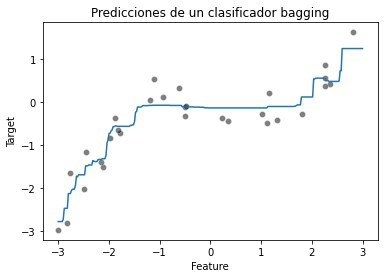

In [26]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagged_trees.predict(X_test)
plt.plot(X_test["Feature"], y_pred)
_ = plt.title("Predicciones de un clasificador bagging")

Debido a que hemos usado 100 árboles en el conjunto, las predicción media es ligeramente más suave pero muy similar a la del gráfico anterior. Es posible acceder después del entrenamiento a los modelos internos del conjunto almacenados como una lista de Python en el atributo `bagged_trees.estimators_`.

Comparemos las predicciones de los modelos base con sus medias:

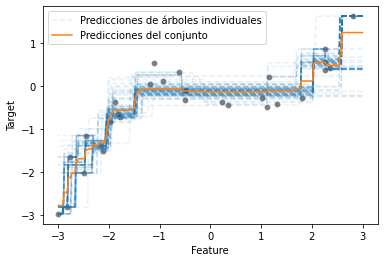

In [27]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predicciones de árboles individuales" if tree_idx == 0 else None
    # convertirmos `X_test` a un array Numpy para evitar el warning de scikit-learn
    y_pred = tree.predict(X_test.to_numpy())
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagged_trees.predict(X_test)
plt.plot(X_test["Feature"], y_pred,
         color="tab:orange", label="Predicciones del conjunto")
_ = plt.legend()

Usamos un valor bajo del parámetro de opacidad `alpha` para apreciar mejor el solape en las funciones de predicción de los árboles individuales.

Esta visualización nos da algunas ideas sobre la incertidumbre de las predicciones en diferentes áreas del espacio de features.

## Pipelines de bagging complejos

Aunque hemos usado un árbol de decisión como modelo de base, nada nos impide que usemos cualquier otro tipo de modelo.

Como sabemos que la función de generación de los datos originales es una transformación polinomial ruidosa de la variable de entrada, intentemos entrenar un pipeline de regresión polinomial bagged en este dataset.

In [28]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

El pipeline en primer lugar escala los datos a un rango 0-1 con `MinMaxScaler`. Despupés extrae features polinomiales de grado 4. Las features resultantes permanecerán en el rango 0-1 por construcción: si `x` se encuentra en el rango 0-1, entonces `x ** n` también se encontrará en el rango 0-1 para cualquier valor de `n`.

Después el pipeline alimenta las features no lineales resultantes a un modelo de regresión lineal regularizado para la predicción final de la variable objetivo.

Nótese que se ha usado intencionadamente un valor pequeño para el parámetro de regularización `alpha`, ya que esperamos que el conjunto bagging funcione bien con modelos de base ligeramente overfitting.

El conjunto en sí mismo se construye simplemente pasando el pipeline resultante al paráemtro `base_estimator` de la clase `BaggingRegressor`:

In [29]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('polynomialfeatures',
                                                 PolynomialFeatures(degree=4)),
                                                ('ridge', Ridge(alpha=1e-10))]),
                 n_estimators=100, random_state=0)

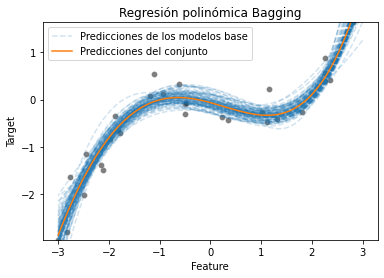

In [31]:
for i, regressor in enumerate(bagging.estimators_):
    # convertirmos `X_test` a un array Numpy para evitar el warning de scikit-learn
    regressor_predictions = regressor.predict(X_test.to_numpy())
    base_model_line = plt.plot(
        X_test["Feature"], regressor_predictions, linestyle="--", alpha=0.2,
        label="Predicciones de los modelos base" if i == 0 else None,
        color="tab:blue"
    )

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagging.predict(X_test)
plt.plot(X_test["Feature"], y_pred,
         color="tab:orange", label="Predicciones del conjunto")
plt.ylim(y_train.min(), y_train.max())
plt.legend()
_ = plt.title("Regresión polinómica Bagging")

Las predicciones de este modelo de regresión polinómica bagged parece cualitativamente mejor que los áboles bagging. Esto era algo esperado dado que el modelo de base refleja mejor nuestro conocimiento del proceso de generación de los datos verdaderos.

De nuevo las diferentes opacidades inducidas por el solapamiento de las líneas azules nos permite apreciar la incertidumbre de las predicciones en el conjunto bagged.

Nótese que el procedimiento de bootstrapping es una herramienta genérica de estadística y no está limitada a construir conjuntos de modelos de machine learning. Se puede obtener más detalle sobre este punto en el [artículo de Wikipedia sobre bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).